In [21]:
import pandas as pd
import numpy as np
import datetime as dt
import time
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
import statsmodels.api as sm # statsmodel 기본 import
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms 
import sklearn as sk
from patsy import dmatrix

##### 다항 회귀의 차수 결정
- "1. mean값이 더 높고
- "2. std값이 더 낮고
- "3. 1과2가 비슷하다면, "차수"가 더 낮은 (덜 복잡한) 모델을 선택

In [24]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.cross_validation import cross_val_score

n_samples = 1000
np.random.seed(0)
X = np.sort(np.random.rand(n_samples))
y = np.cos(1.5 * np.pi * X) + np.random.randn(n_samples) * 0.1
X = X[:, np.newaxis]
K = 100

def cv_mse(degree):
    polynomial_features = PolynomialFeatures(degree=degree)
    linear_regression = LinearRegression()
    model = Pipeline([("polynomial_features", polynomial_features),
                      ("linear_regression", linear_regression)])
    scores = -cross_val_score(model, X, y, "neg_mean_squared_error", cv=K)
    return scores

0.0130824469849 0.00760649444156


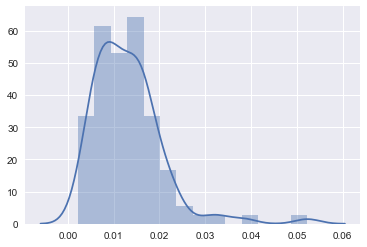

In [25]:
scores1 = cv_mse(3)
sns.distplot(scores1)
print(scores1.mean(), scores1.std())

In [26]:
D = 9
degrees = 2**np.arange(D)
all_scores = np.zeros((K, D))
for i, d in enumerate(degrees):
    scores = cv_mse(d)
    all_scores[:, i] = scores
df = pd.DataFrame(-np.log(all_scores), columns=degrees)
df.describe()

,1,2,4,8,16,32,64,128,256
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,2.152711,3.431163,4.735579,4.757005,4.746503,4.677245,4.605754,4.542724,4.473064
std,1.197341,0.801431,0.470647,0.464274,0.481904,0.696306,1.260506,1.803517,2.609404
min,-0.143751,1.023711,3.757597,3.746899,3.703366,-0.221971,-6.497554,-12.519507,-20.869533
25%,1.283354,2.877161,4.449526,4.447033,4.426597,4.411030,4.410247,4.363565,4.395252
50%,1.912740,3.341536,4.659961,4.698884,4.686885,4.667375,4.676816,4.657987,4.671454
75%,2.922163,3.963974,5.023880,5.012029,5.031433,5.031274,5.035135,4.999756,5.009460
max,5.195028,5.061568,6.386555,6.284238,6.139301,6.196094,6.307032,6.376833,6.352209


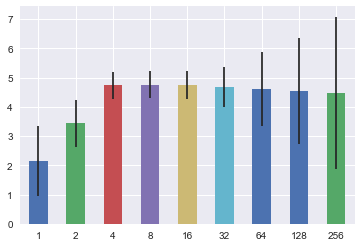

In [27]:
df.mean().plot(kind="bar", rot=0, yerr=df.std())
plt.show()

##### 정규화 하이퍼 모수 최적화 : cv_score를 최대로 만드는 alpha값

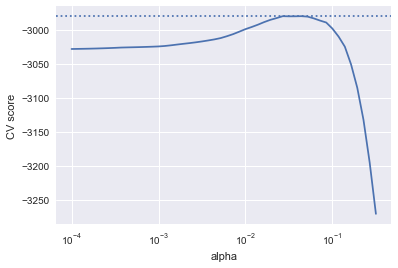

In [28]:
from sklearn.datasets import load_diabetes
from sklearn.linear_model import Lasso
from sklearn.cross_validation import cross_val_score

data = load_diabetes()
X = data.data[:200]
y = data.target[:200]

model = Lasso()
alphas = np.logspace(-4, -.5, 50)

scores = list()

for alpha in alphas:
    model.alpha = alpha
    this_scores = cross_val_score(model, X, y, "neg_mean_squared_error", cv=5)
    scores.append(np.mean(this_scores))

plt.semilogx(alphas, scores)
plt.ylabel('CV score')
plt.xlabel('alpha')
plt.axhline(np.max(scores), linestyle=':')
plt.show()

0.0439397056076


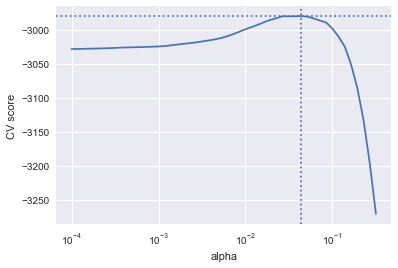

In [29]:
from sklearn.linear_model import LassoCV

alphas = np.logspace(-4, -.5, 50)
lasso_cv = LassoCV(alphas=alphas, cv=5)
lasso_cv.fit(X, y)

print(lasso_cv.alpha_ )

scores = -lasso_cv.mse_path_.mean(axis=1)
plt.semilogx(lasso_cv.alphas_, scores)
plt.axhline(np.max(scores), linestyle=':')    
plt.axvline(lasso_cv.alpha_ , linestyle=':')   
plt.ylabel('CV score')
plt.xlabel('alpha')
plt.show()

##### One Standard Error Rule : cv_score가 조금 낮더라도 제약조건이 더 강한 (alpha값이 더 큰) 모델을 선택하는 뷰

0.117876863479


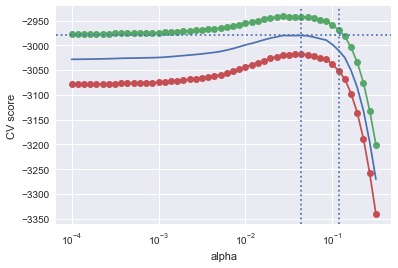

In [30]:
from sklearn.linear_model import LassoCV

alphas = np.logspace(-4, -.5, 50)
lasso_cv = LassoCV(alphas=alphas, cv=5)
lasso_cv.fit(X, y)

scores = -lasso_cv.mse_path_.mean(axis=1)
scores_std = lasso_cv.mse_path_.std(axis=1)
scores_std1 = scores + scores_std / np.sqrt(len(lasso_cv.mse_path_))
scores_std2 = scores - scores_std / np.sqrt(len(lasso_cv.mse_path_))

alpha_1se = lasso_cv.alphas_[np.argmax(scores_std1 > np.max(scores))]
print(alpha_1se)

plt.semilogx(lasso_cv.alphas_, scores)
plt.semilogx(lasso_cv.alphas_, scores_std1, 'o-')
plt.semilogx(lasso_cv.alphas_, scores_std2, 'o-')
plt.axhline(np.max(scores), linestyle=':')    
plt.axvline(lasso_cv.alpha_ , linestyle=':')   
plt.axvline(alpha_1se, linestyle=':')   
plt.ylabel('CV score')
plt.xlabel('alpha')
plt.show()